In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fmin_cg, minimize
import h5py
c = 2.99792458e8   # m/s

In [2]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)

def gamma(v):
    return 1. / np.sqrt(1. - (v/c) ** 2)

def dlndopplerdv(v):
    dv = doppler(v)
    return -1. * gamma(v) / (2. * c) * (1. / dv  + dv)

def state(v, xs, xps):
    '''
    outputs: (M, Mp, v, xs, ms, mps, ehs, bees, seas)
    M and Mp are the lengths of data and model wavelength grids
    v is the RV
    xs is the wavelength values of the data grid
    ms is the data index m at which there is an interpolated model value
    mps is the model index m' from which we interpolate to ms
    ehs, bees, and seas go into the coefficients of interpolation
    '''
    # every input must be 1-d
    M = len(xs)
    Mp = len(xps)
    xps_shifted = xps + np.log(doppler(v))
    ms = np.arange(M)
    mps = np.searchsorted(xps_shifted, xs, side='left')
    good = (mps > 0) * (mps < Mp)
    ms = ms[good]
    mps = mps[good]
    ehs = xps_shifted[mps] - xs[ms]
    bees = xs[ms] - xps_shifted[mps - 1]
    seas = ehs + bees
    return (M, Mp, v, xs, ms, mps, ehs, bees, seas)

def Pdot(state, vec):
    # takes state and model flux vector, returns (shifted) model interpolated into data space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = vec[mps - 1] * ehs / seas + vec[mps] * bees / seas
    return result

def dotP(state, vec):
    # takes state and data flux vector, returns data interpolated into (shifted) model space
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    result[mps - 1] += vec[ms] * ehs / seas
    result[mps] += vec[ms] * bees / seas
    return result

def dotdPdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(Mp)
    foos = vec[ms] / seas * dlndopplerdv(v) # * xs[ms] ??
    result[mps - 1] += foos
    result[mps] -= foos
    return result

def dPdotdv(state, vec):
    # unpack state
    M, Mp, v, xs, ms, mps, ehs, bees, seas = state
    # do shit
    result = np.zeros(M)
    result[ms] = (vec[mps - 1] - vec[mps]) * dlndopplerdv(v) / seas
    return result

In [4]:
with h5py.File('../data/hip14501.hdf5', 'r') as f:
    N = 16
    inds = (f['xs'][:] > 5900.) & (f['xs'][:] < 6000.)
    data = np.copy(f['data'])[:N,inds]
    data_xs = np.log(np.copy(f['xs'][inds]))
    ivars = np.copy(f['ivars'])[:N,inds]
    true_rvs = np.copy(f['true_rvs'])[:N]
    bervs = np.copy(f['berv'])[:N] * -1.e3

for i in xrange(len(data)):
    data[i] /= np.median(data[i])
    
data = np.log(data)

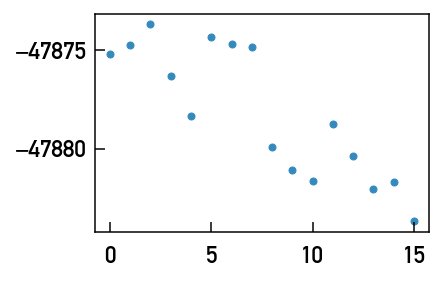

In [8]:
plt.scatter(np.arange(N),true_rvs - bervs)

(-0.05, 0.05)

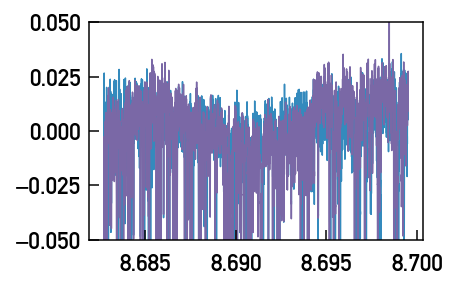

In [9]:
plt.plot(data_xs, data[0,:])
plt.plot(data_xs, data[10,:])
plt.ylim([-0.05, 0.05])

In [10]:
def make_template(all_data, rvs, xs, dx):
    """
    `all_data`: `[N, M]` array of pixels
    `rvs`: `[N]` array of RVs
    `xs`: `[M]` array of wavelength values
    `dx`: linear spacing desired for template wavelength grid (A)
    """
    (N,M) = np.shape(all_data)
    all_xs = np.empty_like(all_data)
    for i in range(N):
        all_xs[i,:] = xs - np.log(doppler(rvs[i])) # shift to rest frame
    all_data, all_xs = np.ravel(all_data), np.ravel(all_xs)
    tiny = 10.
    template_xs = np.arange(min(all_xs)-tiny*dx, max(all_xs)+tiny*dx, dx)
    template_ys = np.nan + np.zeros_like(template_xs)
    for i,t in enumerate(template_xs):
        ind = (all_xs >= t-dx/2.) & (all_xs < t+dx/2.)
        if np.sum(ind) > 0:
            template_ys[i] = np.nanmedian(all_data[ind])
    ind_nan = np.isnan(template_ys)
    template_ys.flat[ind_nan] = np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan]) #np.interp(template_xs[ind_nan], template_xs[~ind_nan], template_ys[~ind_nan])
    return template_xs, template_ys

def subtract_template(data_xs, data, model_xs_t, model_ys_t, rvs_t):
    (N,M) = np.shape(data)
    data_sub = np.copy(data)
    for n,v in enumerate(rvs_t):
        s = state(v, data_xs, model_xs_t)
        model_ys_t_shifted = Pdot(s, model_ys_t)
        data_sub[n,:] -= np.ravel(model_ys_t_shifted)
        if n == 0:
            plt.plot(data_xs, data[n,:], color='k')
            plt.plot(data_xs, data_sub[n,:], color='blue')
            plt.plot(data_xs, np.ravel(model_ys_t_shifted), color='red')
    return data_sub

In [11]:
x0_star = -np.copy(bervs)
x0_star -= np.mean(x0_star)
x0_t = np.zeros(N)
model_xs_star, model_ys_star = make_template(data, x0_star, data_xs, np.log(6000.01) - np.log(6000.))
model_xs_t, model_ys_t = make_template(data, x0_t, data_xs, np.log(6000.01) - np.log(6000.))

(-0.1, 0.1)

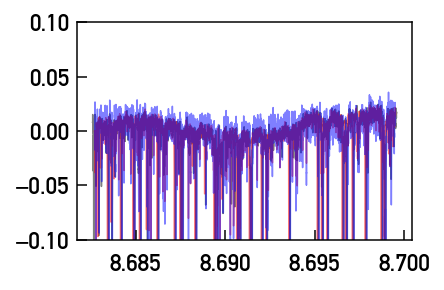

In [12]:
plt.plot(model_xs_star, model_ys_star, color='k', alpha=0.5)
plt.plot(model_xs_t, model_ys_t, color='red', alpha=0.5)
plt.plot(data_xs, data[0,:], color='blue', alpha=0.5)
plt.ylim([-0.1, 0.1])

In [13]:
def rv_lnprior(rvs):
    return -0.5 * np.mean(rvs)**2/1.**2

def drv_lnprior_dv(rvs):
    return np.zeros_like(rvs) - np.mean(rvs)/1.**2/len(rvs)

def lnlike_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_star, model_ys_star)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_star)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_star)
    return -1 * lnpost, -1 * dlnpost_dv

def lnlike_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    dlnlike_dv = np.zeros(N)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dpd_dv = dPdotdv(state_t, model_ys_t)
        dlnlike_dv[n] = np.sum((data[n,:] - pd) * ivars[n,:] * dpd_dv)
    lnpost = lnlike + rv_lnprior(rvs_t)
    dlnpost_dv = dlnlike_dv + drv_lnprior_dv(rvs_t)
    return -1 * lnpost, -1 * dlnpost_dv



In [14]:
def model_ys_lnprior(w):
    return -0.5 * np.sum(w**2)/100.**2


def dmodel_ys_lnprior_dw(w):
    return -1.*w / 100.**2


def dlnlike_star_dw_star(model_ys_star, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    try:
        N = len(rvs_star)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_star)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_star = dotP(state_star, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_star
    lnprior = model_ys_lnprior(model_ys_star)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_star)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

def dlnlike_t_dw_t(model_ys_t, rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    try:
        N = len(rvs_t)
    except:
        N = 1  
    lnlike = 0.
    Mp = len(model_xs_t)
    dlnlike_dw = np.zeros(Mp)
    for n in range(N):
        state_star = state(rvs_star[n], data_xs, model_xs_star)
        pd_star = Pdot(state_star, model_ys_star)
        state_t = state(rvs_t[n], data_xs, model_xs_t)
        pd_t = Pdot(state_t, model_ys_t)
        pd = pd_star + pd_t
        dp_t = dotP(state_t, (data[n,:] - pd)*ivars[n,:]) 
        lnlike += -0.5 * np.sum((data[n,:] - pd)**2 * ivars[n,:])
        dlnlike_dw += dp_t
    lnprior = model_ys_lnprior(model_ys_t)
    dlnprior = dmodel_ys_lnprior_dw(model_ys_t)
    return -lnlike - lnprior, -dlnlike_dw - dlnprior

In [15]:
def improve_telluric_model(model_ys_t, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t):
    w = np.copy(model_ys_t)
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_t_dw_t(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
        w -= 5e-7 * dlnlike_dw    
    return w

def improve_star_model(model_ys_star, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t):
    w = np.copy(model_ys_star + np.random.normal(0, 0.01, len(model_ys_star)))
    for i in range(50):
        lnlike, dlnlike_dw = dlnlike_star_dw_star(w, x0_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
        w -= 5e-7 * dlnlike_dw 
    return w

Fitting stellar RVs...
         Current function value: 7424939.142821
         Iterations: 66
         Function evaluations: 127
         Gradient evaluations: 117
Star model improved. Fitting telluric RVs...
         Current function value: 963140.388157
         Iterations: 167
         Function evaluations: 270
         Gradient evaluations: 262
iter 0: star std = 1266.88, telluric std = 452.92


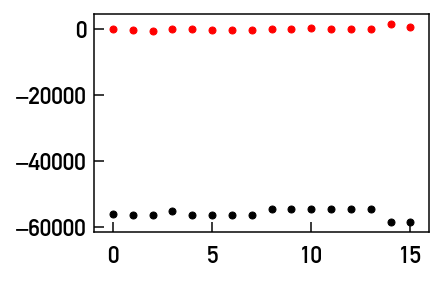

Fitting stellar RVs...
         Current function value: 549709.071036
         Iterations: 31
         Function evaluations: 75
         Gradient evaluations: 68
Star model improved. Fitting telluric RVs...
         Current function value: 350069.228487
         Iterations: 124
         Function evaluations: 181
         Gradient evaluations: 176
iter 1: star std = 566.76, telluric std = 514.02


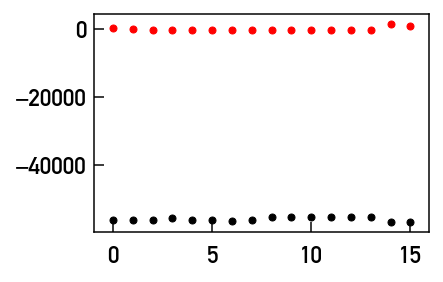

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 286790.181238
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 230651.660397
         Iterations: 77
         Function evaluations: 87
         Gradient evaluations: 87
iter 2: star std = 303.84, telluric std = 486.71


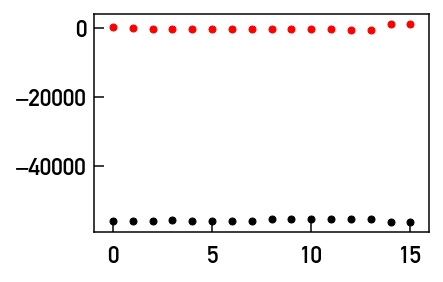

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 214760.906463
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 193929.171986
         Iterations: 48
         Function evaluations: 53
         Gradient evaluations: 53
iter 3: star std = 167.60, telluric std = 397.15


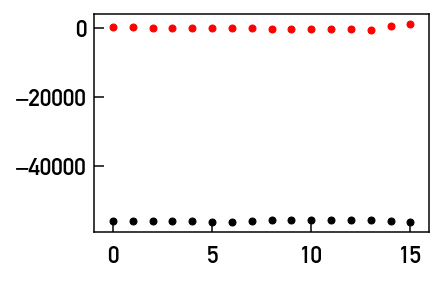

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 188979.147333
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 180053.179965
         Iterations: 46
         Function evaluations: 51
         Gradient evaluations: 51
iter 4: star std = 91.94, telluric std = 307.79


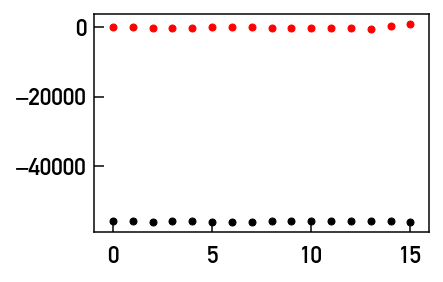

In [16]:
for n in range(5):
    print "Fitting stellar RVs..."
    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    print "Star model improved. Fitting telluric RVs..."
    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    
    x0_star = soln_star
    x0_t = soln_t

    print "iter {0}: star std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star + true_rvs), np.std(soln_t))
    plt.plot(np.arange(N), soln_star + true_rvs - np.mean(soln_star + true_rvs), color='k')
    plt.plot(np.arange(N), soln_t - np.mean(soln_t), color='red')
    plt.show()


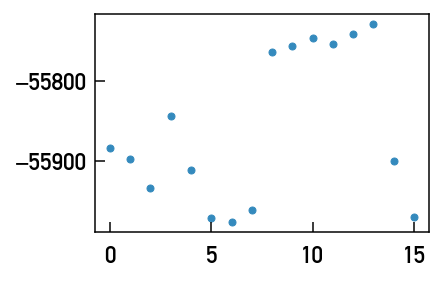

In [20]:
plt.scatter(np.arange(N), soln_star+true_rvs)

(-0.05, 0.05)

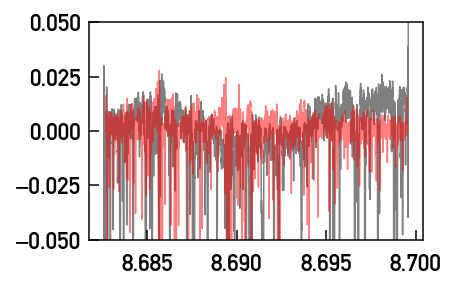

In [22]:
plt.plot(model_xs_star, model_ys_star, 'k', alpha=0.5)
plt.plot(model_xs_t, model_ys_t, 'r', alpha=0.5)
plt.ylim([-0.05, 0.05])

In [ ]:
print len(data_xs)
print len(model_xs_star)
print len(model_xs_t)

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 178627.457730
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 174571.114965
         Iterations: 40
         Function evaluations: 45
         Gradient evaluations: 45
iter 0: star residual std = 51.49, telluric std = 232.03


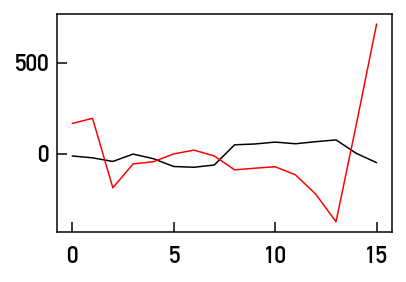

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 174108.995070
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 171964.870864
         Iterations: 53
         Function evaluations: 61
         Gradient evaluations: 61
iter 1: star residual std = 29.08, telluric std = 152.53


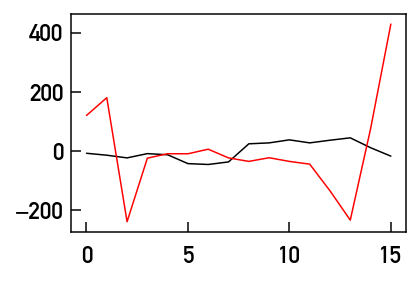

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 171602.989081
         Iterations: 22
         Function evaluations: 24
         Gradient evaluations: 24
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 170431.872263
         Iterations: 47
         Function evaluations: 52
         Gradient evaluations: 52
iter 2: star residual std = 16.29, telluric std = 106.22


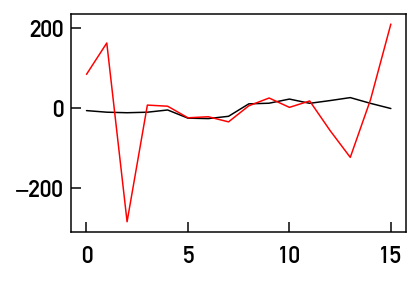

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 170188.933686
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 169473.640371
         Iterations: 34
         Function evaluations: 41
         Gradient evaluations: 41
iter 3: star residual std = 8.83, telluric std = 92.35


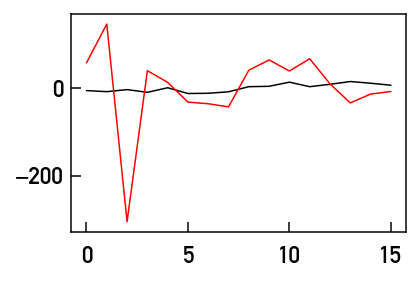

Fitting stellar RVs...
Optimization terminated successfully.
         Current function value: 169251.378727
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Star model improved. Fitting telluric RVs...
Optimization terminated successfully.
         Current function value: 168814.177603
         Iterations: 55
         Function evaluations: 61
         Gradient evaluations: 61
iter 4: star residual std = 5.64, telluric std = 113.83


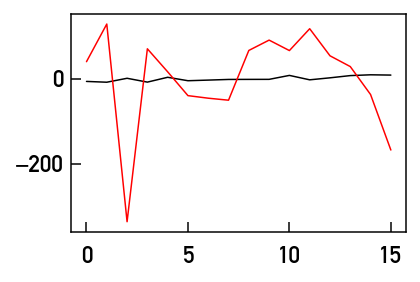

In [23]:
for n in range(5):
    print "Fitting stellar RVs..."
    soln_star =  minimize(lnlike_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, x0_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    print "Star model improved. Fitting telluric RVs..."
    soln_t =  minimize(lnlike_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     method='BFGS', jac=True, options={'disp':True, 'gtol':1.e-2, 'eps':1.5e-5})['x']
    
    model_ys_t = improve_telluric_model(model_ys_t, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t)
    model_ys_star = improve_star_model(model_ys_star, soln_star, soln_t, data_xs, data, ivars, model_xs_star, model_xs_t, model_ys_t)
    
    x0_star = soln_star
    x0_t = soln_t

    print "iter {0}: star residual std = {1:.2f}, telluric std = {2:.2f}".format(n, np.std(soln_star + true_rvs), np.std(soln_t))
    plt.plot(np.arange(N), soln_star + true_rvs - np.mean(soln_star + true_rvs), color='k')
    plt.plot(np.arange(N), soln_t - np.mean(soln_t), color='red')
    plt.show()


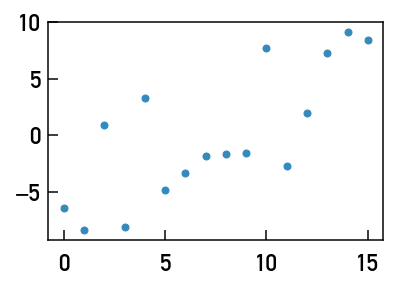

In [28]:
plt.scatter(np.arange(N), soln_star+true_rvs - np.mean(soln_star+true_rvs))

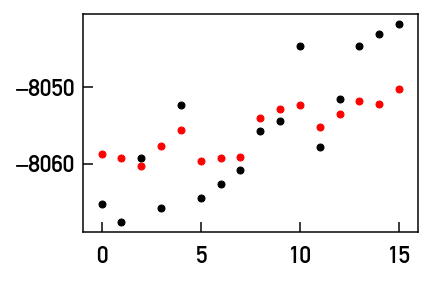

In [27]:
plt.scatter(np.arange(N), soln_star - np.mean(soln_star) + bervs, color='k')
plt.scatter(np.arange(N), -true_rvs + np.mean(true_rvs) + bervs, color='r')